In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from state_cleaner import *
from datetime import datetime
import requests
import json

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.chdir('../..')
os.chdir('CovidMobile')
os.getcwd()

'/Users/samismalling/Documents/mobility-report-data-extractor-master/CovidMobile'

# Census Data

In [3]:
df_col_headers = pd.read_csv('data/DataDict.txt_2020-04-21', sep='\t', header=None)
df_county_data = pd.read_csv('data/DataSet.txt_2020-04-21', sep=',')
df_county_names = pd.read_csv('data/FIPS_CountyName.txt_2020-04-21', sep='delimiter', header=None)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
df_county_names.tail()

,0
3190,"56037 Sweetwater County, WY"
3191,"56039 Teton County, WY"
3192,"56041 Uinta County, WY"
3193,"56043 Washakie County, WY"
3194,"56045 Weston County, WY"


In [5]:
df_county_names = df_county_names[0].str.split(' ',n=1,expand=True)
df_county_names = pd.concat([df_county_names[0],df_county_names[1].str.split(',',n=1,expand=True)],axis=1)
df_county_names.columns = ['FIPS','County','State']
df_county_names['State'] = df_county_names['State'].str.replace(' ', '')
df_county_names.shape,df_county_names.head()

((3195, 3),
     FIPS          County State
 0  00000   UNITED STATES  None
 1  01000         ALABAMA  None
 2  01001  Autauga County    AL
 3  01003  Baldwin County    AL
 4  01005  Barbour County    AL)

In [6]:
df_col_headers = df_col_headers[0].str.split(' ',n=1,expand=True)
df_col_headers = pd.concat([df_col_headers[0],df_col_headers[1].str.split('\s+\s+',n=1,expand=True)],axis=1)
df_col_headers.columns = ['code','var_name','extra']
df_col_headers.drop([0],inplace=True)
df_col_headers.head()



,code,var_name,extra
1,STATECOU,FIPS State and County code,None
2,PST045214,"Population, 2014 estimate",ABS 0 318857056 86 318857056 CENSUS
3,PST045213,"Population, 2013 estimate",ABS 0 316497531 89 316497531 CENSUS
4,PST040210,"Population, 2010 (April 1) estimates base",ABS 0 308758105 82 308758105 CENSUS
5,PST120214,"Population, percent change - April 1, 2010 to ...",PCT 1 3.3 -17.0 72.9 CENSUS


In [7]:
df_county_data.columns = df_col_headers['var_name'].values

In [8]:
df_county_data.head()

,FIPS State and County code,"Population, 2014 estimate","Population, 2013 estimate","Population, 2010 (April 1) estimates base","Population, percent change - April 1, 2010 to July 1, 2014","Population, percent change - April 1, 2010 to July 1, 2013","Population, 2010","Persons under 5 years, percent, 2013","Persons under 18 years, percent, 2013","Persons 65 years and over, percent, 2013",...,"Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Manufacturers shipments, 2007 ($1,000)","Merchant wholesaler sales, 2007 ($1,000)","Retail sales, 2007 ($1,000)","Retail sales per capita, 2007","Accommodation and food services sales, 2007 ($1,000)","Building permits, 2014","Land area in square miles, 2010","Population per square mile, 2010"
0,0,318857056,316497531,308758105,3.3,2.5,308745538,6.3,23.3,14.1,...,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,1046363,3531905.43,87.4
1,1000,4849377,4833996,4780127,1.4,1.1,4779736,6.1,23.0,14.9,...,1.2,28.1,112858843,52252752,57344851,12364,6426342,13369,50645.33,94.4
2,1001,55395,55136,54571,1.5,1.0,54571,6.1,25.4,13.5,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
3,1003,200111,195443,182265,9.8,7.2,182265,5.7,22.4,18.1,...,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
4,1005,26887,26978,27457,-2.1,-1.7,27457,5.8,21.1,15.9,...,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0


# Build Dataset

In [9]:
os.getcwd()

'/Users/samismalling/Documents/mobility-report-data-extractor-master/CovidMobile'

In [10]:
full = pd.read_csv('data/Global_Mobility_Report.csv')
full['source'] = 'google'

full.rename(columns={'transit_stations_percent_change_from_baseline':'transit',
                 'residential_percent_change_from_baseline':'homes',
                 'grocery_and_pharmacy_percent_change_from_baseline':'food_drugs',
                'retail_and_recreation_percent_change_from_baseline':'retail',
                'workplaces_percent_change_from_baseline':'work',
                'parks_percent_change_from_baseline':'park'},inplace=True)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
full.columns.values

array(['country_region_code', 'country_region', 'sub_region_1',
       'sub_region_2', 'date', 'retail', 'food_drugs', 'park', 'transit',
       'work', 'homes', 'source'], dtype=object)

In [12]:
full = full[full['country_region_code']=='US'].rename(columns={'sub_region_1':'state','sub_region_2':'county'}) 

In [13]:
full['state_abb'] = full['state'].apply(replace_acronym)
full['county'] = np.where(full['county'].isnull(),full['state_abb'] ,full['county'] )

In [14]:
df_county_names['Region'] = np.where(df_county_names['State'].isnull(),np.nan,df_county_names['County'])
df_county_names['State'] = df_county_names['State'].fillna(method='backfill')
df_county_names['Region'] = np.where(df_county_names['Region'].isnull(),df_county_names['State'],df_county_names['Region'])
print(df_county_names.head())
df_county_names.drop([0],inplace=True)
df_county_names.rename(columns={'State':'state_abb','Region':'county'},inplace=True)

    FIPS          County State          Region
0  00000   UNITED STATES    AL              AL
1  01000         ALABAMA    AL              AL
2  01001  Autauga County    AL  Autauga County
3  01003  Baldwin County    AL  Baldwin County
4  01005  Barbour County    AL  Barbour County


In [15]:
replc_county = {'Anchorage' :'Anchorage Municipality',
'Bethel' :'Bethel Census Area',
'Fairbanks North Star' :'Fairbanks North Star Borough',
'Juneau' : 'Juneau City and Borough',
'Kenai Peninsula Borough' :'Kenai Peninsula Borough',
'Ketchikan Gateway' :'Ketchikan Gateway Borough',
'Kodiak Island':'Kodiak Island Borough',
'Matanuska-Susitna':'Matanuska-Susitna Borough',
'North Slope':'North Slope Borough',
'Sitka':'Sitka City and Borough',
'Southeast Fairbanks':'Southeast Fairbanks Census Area',
'Valdez-Cordova':'Valdez-Cordova Census Area',
'Doña Ana County':'Doa Ana'}

In [16]:
df_county_data.rename(columns={' FIPS State and County code':'FIPS'},inplace=True)
df_county_data['FIPS'] = df_county_data['FIPS'].astype(float)
df_county_names['county'] = df_county_names['county'].str.replace(' city','')
full['county'] = full['county'].replace(replc_county)
full_tog = full.merge(df_county_names[['FIPS','state_abb','county']],on=['state_abb','county'],how='left',indicator=True)
full_tog['FIPS'] = full_tog['FIPS'].astype(float)
#dropping old census data
#full_tog = full_tog.merge(df_county_data,on=['FIPS'],how='left',indicator=True)

In [17]:
df_county_names[df_county_names['county']=='NM']['county'].value_counts()

NM    1
Name: county, dtype: int64

In [18]:
print(full_tog['_merge'].value_counts())
full_tog.drop(columns=['_merge'],inplace=True)

both          154946
left_only        114
right_only         0
Name: _merge, dtype: int64


In [19]:
full_tog.date = pd.to_datetime(full_tog.date,errors='coerce') 
full_tog['geo']=np.where(full_tog['county']==full_tog['state_abb'],'state','county')

# USDA

In [20]:
files = ["Education.csv",
"PopulationEstimates.csv",
"PovertyEstimates.csv",
"Unemployment.csv"]

for i,f in enumerate(files):
    df =pd.read_csv('data/{}'.format(f))
    print(df.columns[0])
    df.rename(columns={df.columns[0]:'FIPS'},inplace=True)
    if i ==0:
        usda = df.copy()
        continue
    else:
        usda = usda.merge(df,on=['FIPS'])

FIPS Code
FIPS
FIPStxt
FIPS


In [21]:
usda = pd.concat([usda['FIPS'],usda.filter(like='2018')],axis=1)

In [22]:
full_tog = full_tog.merge(usda,on='FIPS',how='left') 

#### Second CSV File

In [73]:
usda_full = pd.read_excel('./data/food_env_atlas_usda.xls', sheet_name = None)
sheet_names = usda_full.keys()
sheets2keep = ['ACCESS','STORES','RESTAURANTS','ASSISTANCE','INSECURITY']

usda2 = usda_full['Supplemental Data - County']
usda2.rename(columns={'FIPS ': 'FIPS'},inplace=True)
#convert populations from string to numbers:
for col in usda2.iloc[:,3:]:
    usda2[col] = [int(x.replace(',' , '')) for x in usda2[col]]

#add other helpful data
for sheet_name in sheets2keep:
    print(sheet_name)
    usda2 = pd.merge(usda2, usda_full[sheet_name], on = 'FIPS', how = 'left')

ACCESS
STORES
RESTAURANTS
ASSISTANCE
INSECURITY


In [74]:
#get rid of duplicate State and County data:
usda2.iloc[:,~usda2.columns.duplicated()]

#export to cleaned csv:
usda2.to_csv('./data/clean_usda2.csv')

# Neighboring Counties

In [23]:
def keep_one(tup):
    col = tup[1]
    if col == '':
        col = tup[0]
    return col

In [24]:
neighbors = pd.read_csv('data/county_adjacency.csv')


neighbors['count'] = neighbors.groupby(['FIPS','county']).cumcount()
neighbors =neighbors.pivot(index='FIPS',columns='count',values='nearby_FIPS')
neighbors =neighbors.reset_index()
print(neighbors.head())
neighbors.columns = ['FIPS', 'neighbors1', 'neighbors2', 'neighbors3', 'neighbors4', 'neighbors5', 'neighbors6', 'neighbors7', 'neighbors8', 'neighbors9', 'neighbors10', 'neighbors11', 'neighbors12','neighbors13','neighbors14', 'neighbors15']

count    FIPS       0       1       2       3       4       5        6  \
0      1001.0  1001.0  1021.0  1047.0  1051.0  1085.0  1101.0      NaN   
1      1003.0  1003.0  1025.0  1053.0  1097.0  1099.0  1129.0  12033.0   
2      1005.0  1005.0  1011.0  1045.0  1067.0  1109.0  1113.0  13061.0   
3      1007.0  1007.0  1021.0  1065.0  1073.0  1105.0  1117.0   1125.0   
4      1009.0  1009.0  1043.0  1055.0  1073.0  1095.0  1115.0   1127.0   

count        7        8   9  10  11  12  13  14  
0          NaN      NaN NaN NaN NaN NaN NaN NaN  
1          NaN      NaN NaN NaN NaN NaN NaN NaN  
2      13239.0  13259.0 NaN NaN NaN NaN NaN NaN  
3          NaN      NaN NaN NaN NaN NaN NaN NaN  
4          NaN      NaN NaN NaN NaN NaN NaN NaN  


In [25]:
full_tog = full_tog.merge(neighbors, on=['FIPS'],how='left')

# State Orders

In [26]:
orders = pd.read_csv('data/emergency_orders.csv')

orders['soe'] = pd.to_datetime('2020 '  + orders['State of emergency declared'], format='%Y %B %d')
orders['sah'] = pd.to_datetime('2020 '  + orders['Stay at home ordered'], format='%Y %B %d',errors='coerce')
orders['school_year'] = np.where(orders['Schools']=='Yes (remainder of term)',1,0)
orders['bars'] = orders['Bars & sit-down restaurants'].replace({'Yes':1,'Restricted':1,'No':0})
orders['gather'] = np.where(orders['Gatherings banned'].str.contains('All'),1,0)
orders['daycares'] =  orders['Daycares'].replace({'Yes':1,'Restricted':1,'No':0})
orders['non_essential_retail'] =  orders['Non-essential retail'].replace({'Yes':1,'Restricted':1,'No':0,'Regional':0})
orders['travel_restriction'] = orders['Out-of-state travel restrictions'].copy()
orders['state_abb'] = orders['State/territory'].str.replace(' ','',1).apply(replace_acronym)
orders[orders['state_abb'].isnull()]['State/territory']

37      N. Mariana Islands
49     U.S. Virgin Islands
Name: State/territory, dtype: object

In [27]:
cols = ['soe','sah','state_abb','school_year','bars','gather','Gatherings banned','daycares','non_essential_retail','travel_restriction']

In [28]:
full_tog = full_tog.merge(orders[cols],on=['state_abb'],how='left')

# Covid Data (source: NYT)

In [29]:
lst_download = '2020-04-21'

In [30]:
covid_county = pd.read_csv('data/{}_us-counties.csv'.format(lst_download),encoding = "ISO-8859-1")
covid_state = pd.read_csv('data/{}_us-states.csv'.format(lst_download),encoding = "ISO-8859-1")

In [31]:
covid_state['state_abb'] = covid_state['state'].apply(replace_acronym)
covid_state['county'] = covid_state['state_abb'].copy()
covid_state['fips'] = covid_state['fips'] *1000.0
covid_county['state_abb'] = covid_county['state'].apply(replace_acronym)
covid = pd.concat([covid_state,covid_county],axis=0)
covid.date = pd.to_datetime(covid.date,errors='coerce')
covid.rename(columns={'fips':'FIPS'},inplace=True)
covid['FIPS'] = covid['FIPS'].astype(float)
print(covid.shape)
covid.dropna(subset=['FIPS'],inplace=True)
covid[covid['date']>=pd.to_datetime('2020-02-15')].shape
covid['first_case_date']  = covid.groupby(['FIPS'])['date'].transform(min)
covid.sort_values(by=['FIPS','date']).head(20) 

(78486, 7)


,date,state,FIPS,cases,deaths,state_abb,county,first_case_date
586,2020-03-13,Alabama,1000.0,6,0,AL,AL,2020-03-13
637,2020-03-14,Alabama,1000.0,12,0,AL,AL,2020-03-13
689,2020-03-15,Alabama,1000.0,23,0,AL,AL,2020-03-13
742,2020-03-16,Alabama,1000.0,29,0,AL,AL,2020-03-13
795,2020-03-17,Alabama,1000.0,39,0,AL,AL,2020-03-13
849,2020-03-18,Alabama,1000.0,51,0,AL,AL,2020-03-13
903,2020-03-19,Alabama,1000.0,78,0,AL,AL,2020-03-13
957,2020-03-20,Alabama,1000.0,106,0,AL,AL,2020-03-13
1011,2020-03-21,Alabama,1000.0,131,0,AL,AL,2020-03-13
1065,2020-03-22,Alabama,1000.0,157,0,AL,AL,2020-03-13


In [32]:
full_data = full_tog.merge(covid,on=['date','FIPS'],how='left',indicator=True)

In [33]:
full_data.geo.value_counts()

county    152210
state       2907
Name: geo, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


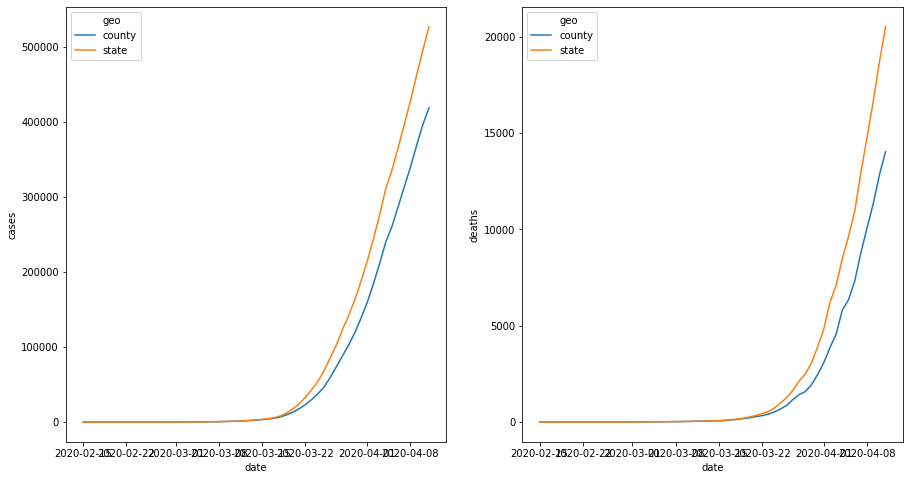

In [34]:
plt_data = full_data.groupby(['geo','date'])['cases','deaths'].sum().reset_index()
f, ax = plt.subplots(1,2,sharex=True,figsize=(15,8))
sns.lineplot(x='date',y='cases',hue='geo',data=plt_data,ax=ax[0])
sns.lineplot(x='date',y='deaths',hue='geo',data=plt_data,ax=ax[1])


In [35]:
full_data.groupby(['geo','date'])['cases','deaths'].sum().reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,geo,date,cases,deaths
0,county,2020-02-15,15.0,0.0
1,county,2020-02-16,15.0,0.0
2,county,2020-02-17,25.0,0.0
3,county,2020-02-18,25.0,0.0
4,county,2020-02-19,25.0,0.0
...,...,...,...,...
109,state,2020-04-07,396848.0,12927.0
110,state,2020-04-08,428231.0,14772.0
111,state,2020-04-09,462402.0,16634.0
112,state,2020-04-10,495555.0,18665.0


In [36]:
full_data.to_csv('data/compiled_{}.csv'.format(str(datetime.datetime.now().date())),index=False)

# Lag mobility data

In [37]:
full_data.columns.values

array(['country_region_code', 'country_region', 'state_x', 'county_x',
       'date', 'retail', 'food_drugs', 'park', 'transit', 'work', 'homes',
       'source', 'state_abb_x', 'FIPS', 'geo', 'POP_ESTIMATE_2018',
       'N_POP_CHG_2018', 'Births_2018', 'Deaths_2018', 'NATURAL_INC_2018',
       'INTERNATIONAL_MIG_2018', 'DOMESTIC_MIG_2018', 'NET_MIG_2018',
       'RESIDUAL_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018',
       'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018',
       'R_DOMESTIC_MIG_2018', 'R_NET_MIG_2018', 'POVALL_2018',
       'CI90LBAll_2018', 'CI90UBALL_2018', 'PCTPOVALL_2018',
       'CI90LBALLP_2018', 'CI90UBALLP_2018', 'POV017_2018',
       'CI90LB017_2018', 'CI90UB017_2018', 'PCTPOV017_2018',
       'CI90LB017P_2018', 'CI90UB017P_2018', 'POV517_2018',
       'CI90LB517_2018', 'CI90UB517_2018', 'PCTPOV517_2018',
       'CI90LB517P_2018', 'CI90UB517P_2018', 'MEDHHINC_2018',
       'CI90LBINC_2018', 'CI90UBINC_2018', 'POV04_2018', 'CI90LB04_2018',
     

# Weather Data from NOAA

In [3]:
fips_to_county = pd.read_csv('./data/ZIP-COUNTY-FIPS_2017-06.csv')

In [4]:
fips_to_county.head()
#len(fips_to_county)

,ZIP,COUNTYNAME,STATE,STCOUNTYFP,CLASSFP
0,36003,Autauga County,AL,1001,H1
1,36006,Autauga County,AL,1001,H1
2,36067,Autauga County,AL,1001,H1
3,36066,Autauga County,AL,1001,H1
4,36703,Autauga County,AL,1001,H1


In [19]:
#Grab weather data from NOAA API:
query = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG&limit=1000&startdate=2020-03-01&enddate=2020-05-01&locationid=ZIP:'
token = 'NVPWXeGxislWKqThiizoffNjnPtUtAcT'
zipcodes = list(fips_to_county['ZIP'][0:6])

In [20]:
query+code

'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG&limit=1000&startdate=2020-03-01&enddate=2020-05-01&locationid=ZIP:36003'

In [21]:
#initialize lists to store data
dates_temp = []
dates_prcp = []
temps = []
prcp = []

for code in zipcodes:
    code = str(code)
    print('working on zip code '+code)
    
    #make the api call
    r = requests.get(query+code, headers={'token':token})
    #load the api response as a json
    #d = json.loads(r.text)

working on zip code 36003


KeyboardInterrupt: 

In [ ]:
#get all items in the response which are average temperature readings
    avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']
    #get all items in the response which are precipitation readings
    avg_prcp = [item for item in d['results'] if item['datatype']=='PRCP']
    
    #get the date field from all average temperature readings
    dates_temp += [item['date'] for item in avg_temps]
    #get the date field from precipitation readings
    dates_prcp += [item['date'] for item in avg_prcp]
    
    #get the actual average temperature from all average temperature readings
    temps += [item['value'] for item in avg_temps]
    #get the actual precipitation from all readings
    prcp += [item['value'] for item in avg_prcp]

In [47]:
import pymongo
#import dnspython
import time
from noaa_sdk import noaa
n = noaa.NOAA()

In [ ]:
from pymongo import MongoClient
# pprint library is used to make the output look more pretty
from pprint import pprint
# connect to MongoDB, change the << MONGODB URL >> to reflect your own connection string
#client = MongoClient('mongodb+srv://ss2676:<jafheT-qeczov-nodze8>@cluster0-ybdtx.mongodb.net/test?retryWrites=true&w=majority')


client = pymongo.MongoClient("mongodb+srv://ss2676:<jafheT-qeczov-nodze8>@cluster0-ybdtx.mongodb.net/test?retryWrites=true&w=majority")
db = client.test

mydb = client["CovidMobile"]
weather = mydb["NOAA Weather"]

forecast = n.get_observations(zip_code, 'US',start='2020-04-28',end='2020-04-30')
x = weather.insert_many(forecast)

print(x)

In [62]:
forecast = n.get_observations(20001, 'US',start='2020-04-28',end='2020-04-30')
f = pd.DataFrame(forecast)
items = ['timestamp','textDescription','temperature','precipitationLast6Hours','relativeHumidity','cloudLayers']
f = f[items]
f.insert(0,'ZIP',zip_code) #add zip code 

In [99]:
dc_weather = pd.DataFrame(columns = ['ZIP','timestamp','textDescription','temperature','precipitationLast6Hours','relativeHumidity','cloudLayers'])
dczips = [20001,20004, 20005, 20036, 20009, 20007, 20010, 20008, 20016]
for code in dczips:
    forecast = n.get_observations(code, 'US',start='2020-04-28',end='2020-04-30')
    for obs in forecast:
        time = obs['timestamp']
        desc = obs['textDescription']
        temp = obs['temperature']['value']
        precip = obs['precipitationLast6Hours']['value']
        hum = obs['relativeHumidity']['value']
        cloud = obs['cloudLayers'][0]['base']['value']
    
        row = [code,time,desc,temp,precip,hum,cloud]
        weather.loc[len(weather)] = row

In [100]:
weather.to_csv('/Users/samismalling/Documents/mobility-report-data-extractor-master/CovidMobile/data/DC_weather_04_28-04_30.csv')

In [ ]:
weather = pd.DataFrame()
bad_zips = []
for zip_code in fips_to_county['ZIP'][0:200]:
    if zip_code not in bad_zips:
        print(zip_code)
        try:
            forecast = n.get_forecasts(zip_code, 'US',hourly = False)
            f = pd.DataFrame(forecast)
            f = f[['startTime','endTime','temperature','windSpeed','windDirection','shortForecast']]
            f.insert(0,'ZIP',zip_code) #add zip code 
            weather = pd.concat([weather, f], ignore_index = True)
        except:
            bad_zips.append(zip_code)
            continue